--- Logistic Regression ---
Accuracy: 0.9524
Precision: 0.9583
Recall: 0.9524
                precision    recall  f1-score   support

         Fresh       1.00      0.80      0.89         5
Onset Spoilage       0.00      0.00      0.00         0
         Ripen       0.88      1.00      0.93         7
       Spoiled       1.00      1.00      1.00         9

      accuracy                           0.95        21
     macro avg       0.72      0.70      0.71        21
  weighted avg       0.96      0.95      0.95        21

------------------------------------------------

--- Linear Regression ---
Accuracy: 0.6667
Precision: 0.9167
Recall: 0.6667
                precision    recall  f1-score   support

         Fresh       1.00      0.20      0.33         5
Onset Spoilage       0.00      0.00      0.00         0
         Ripen       0.75      0.86      0.80         7
       Spoiled       1.00      0.78      0.88         9

      accuracy                           0.67        21
     ma

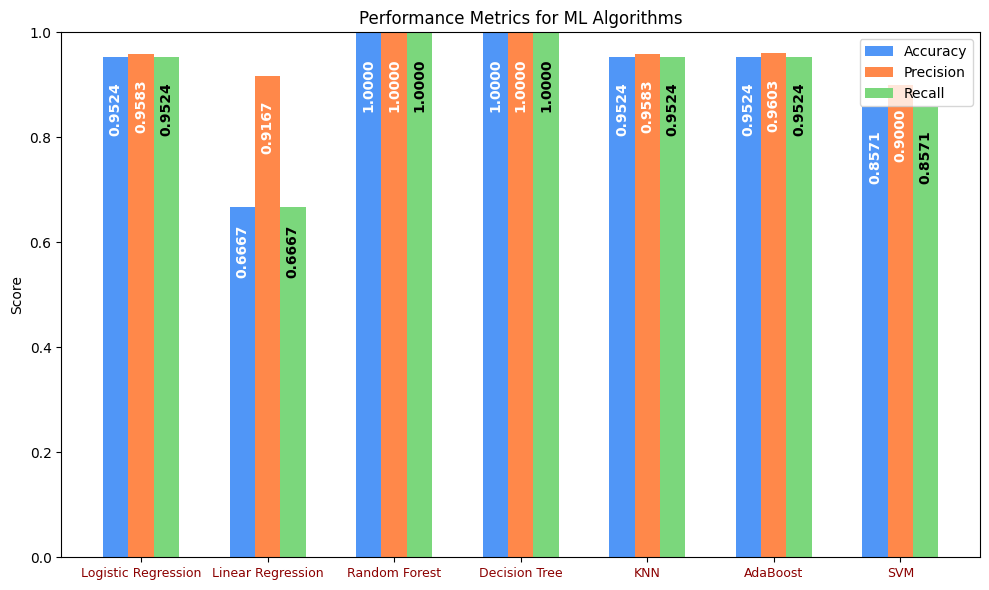

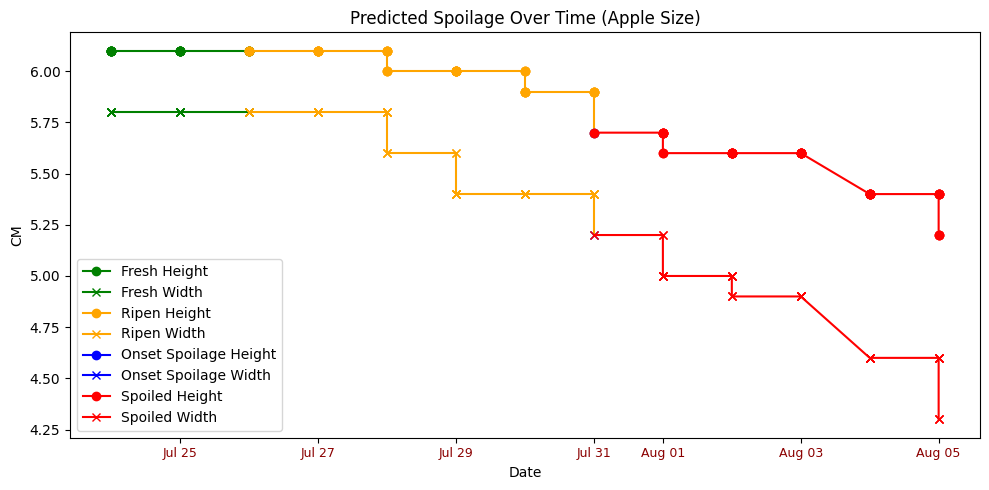

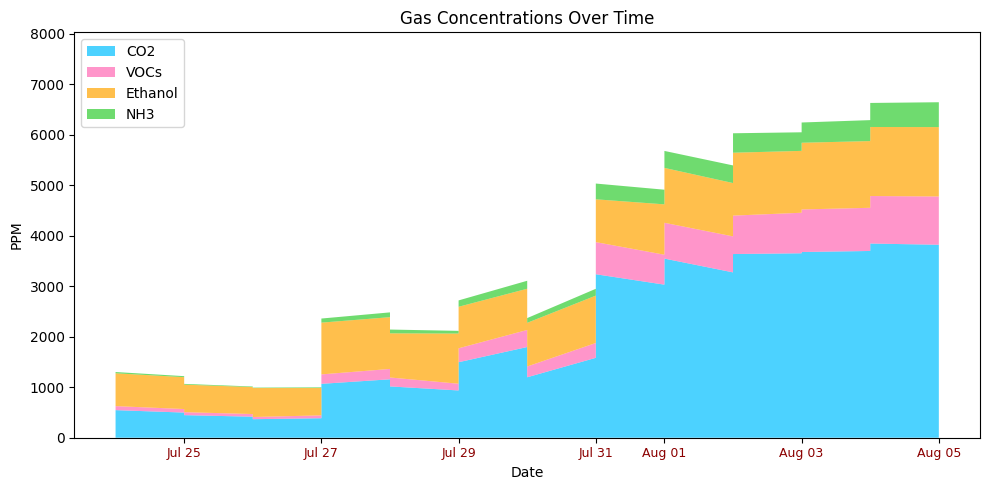

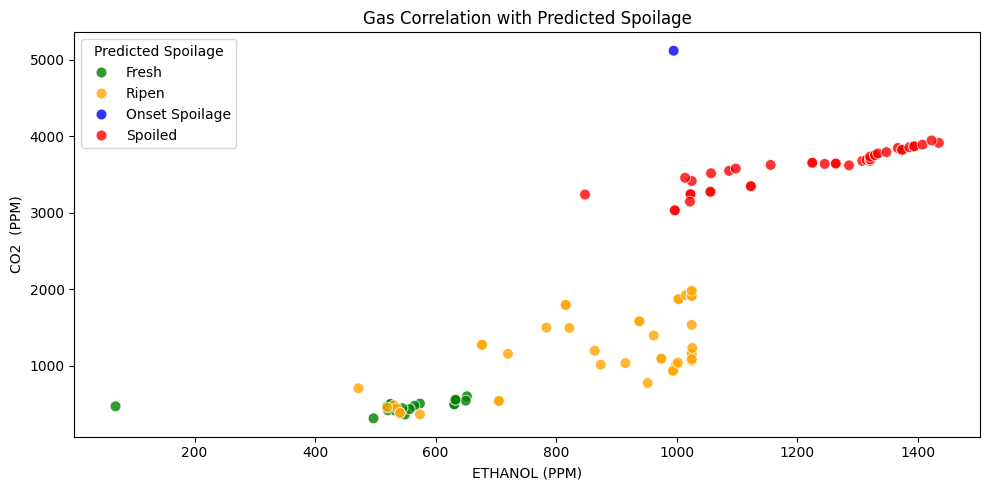

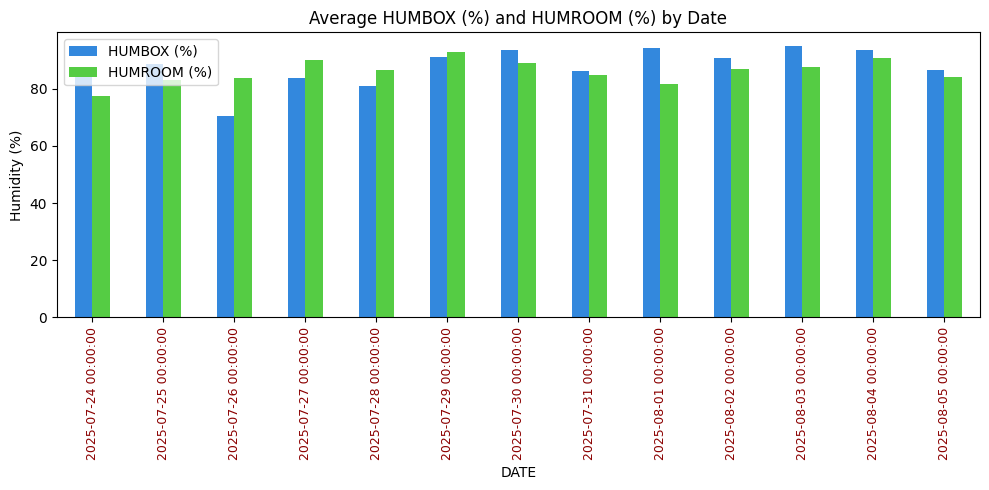

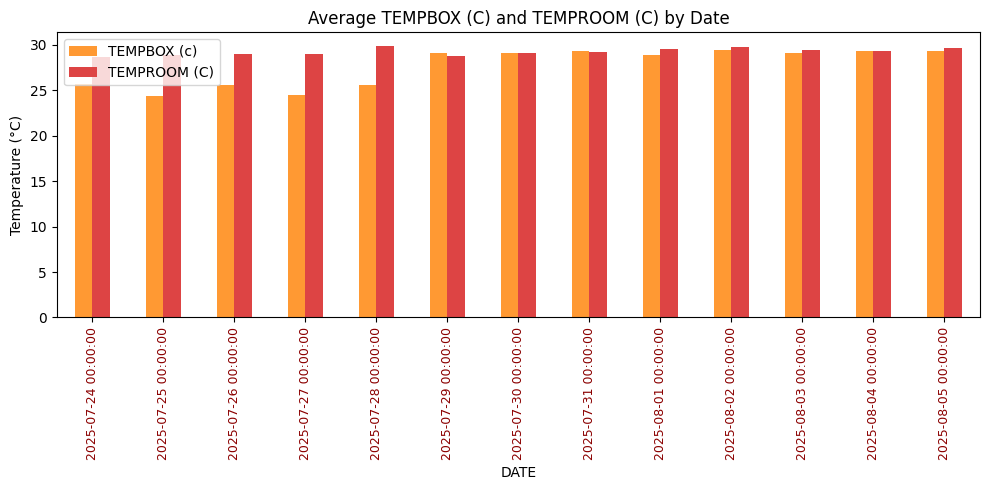

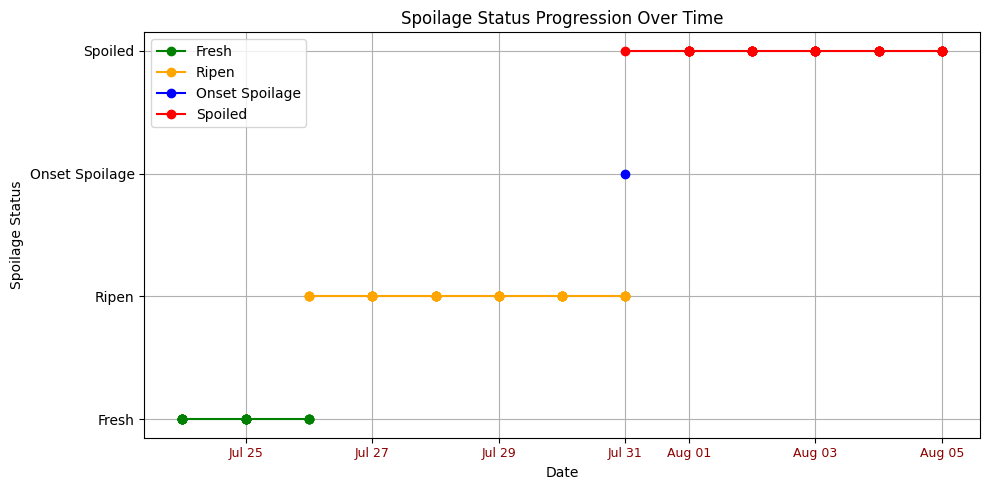

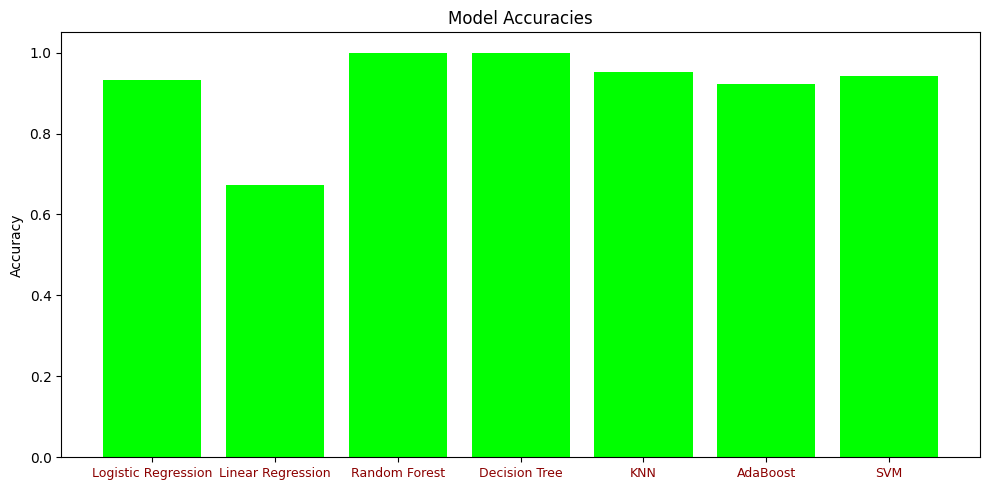

In [5]:
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.dates import DateFormatter
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, classification_report

# --- Step 1: Data Loading and Preprocessing ---
df = pd.read_excel('Apple_Data_Sheet.xlsx')
df.columns = df.columns.str.strip()
df = df.dropna()

# Correctly handle DATE column for plotting
df['DATE'] = pd.to_datetime(df['DATE'], errors='coerce')

exclude_cols = ['Spoilage Status', 'DATE', 'TIME']
features = [col for col in df.columns if col not in exclude_cols and pd.api.types.is_numeric_dtype(df[col])]
X = df[features].values
y = df['Spoilage Status'].values

le = LabelEncoder()
y_enc = le.fit_transform(y)

X_train, X_test, y_train, y_test = train_test_split(X, y_enc, test_size=0.2, random_state=42)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# --- Step 2: Define and Train Models ---
models = {
    'Logistic Regression': LogisticRegression(max_iter=300),
    'Linear Regression': LinearRegression(),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
    'Decision Tree': DecisionTreeClassifier(random_state=42),
    'KNN': KNeighborsClassifier(),
    'AdaBoost': AdaBoostClassifier(random_state=42),
    'SVM': SVC(kernel='linear', probability=True, random_state=42)
}

acc_table = {cls: {} for cls in le.classes_}
metrics_list = []
model_predictions = {}
model_accuracies = {}

for name, model in models.items():
    if name == 'Linear Regression':
        # Linear Regression is a regression model, handle it separately
        model.fit(X_train_scaled, y_train)
        y_pred_cont = model.predict(X_test_scaled)
        # Convert continuous predictions to discrete classes for evaluation
        y_pred = np.clip(np.round(y_pred_cont), 0, len(le.classes_) - 1).astype(int)
    else:
        # All other models are classifiers
        model.fit(X_train_scaled, y_train)
        y_pred = model.predict(X_test_scaled)

    # Now, all y_pred are discrete, so classification metrics work
    cr = classification_report(
        y_test,
        y_pred,
        output_dict=True,
        zero_division=0,
        labels=np.arange(len(le.classes_)),
        target_names=le.classes_
    )

    for cls in le.classes_:
        acc_table[cls][name] = cr[cls]['recall']

    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted', zero_division=0)
    recall = recall_score(y_test, y_pred, average='weighted', zero_division=0)
    metrics_list.append({'Model': name, 'Accuracy': accuracy, 'Precision': precision, 'Recall': recall})

    # Print evaluation report
    print(f'--- {name} ---')
    print(f'Accuracy: {accuracy:.4f}')
    print(f'Precision: {precision:.4f}')
    print(f'Recall: {recall:.4f}')
    print(classification_report(y_test, y_pred, labels=np.arange(len(le.classes_)), target_names=le.classes_, zero_division=0))
    print('------------------------------------------------\n')

# --- Step 3: Performance Visualization ---
acc_df = pd.DataFrame(acc_table).T
acc_df.index.name = 'Spoilage Status'
print("Per-class Accuracy (Recall) Table:")
print(acc_df.round(4))

metrics_df = pd.DataFrame(metrics_list)

plt.figure(figsize=(10, 6))
bar_width = 0.2
x = np.arange(len(metrics_df))
bars1 = plt.bar(x - bar_width, metrics_df['Accuracy'], width=bar_width, color='#5096f7', label='Accuracy')
bars2 = plt.bar(x, metrics_df['Precision'], width=bar_width, color='#ff884a', label='Precision')
bars3 = plt.bar(x + bar_width, metrics_df['Recall'], width=bar_width, color='#7bd77c', label='Recall')

for bars, color in zip([bars1, bars2, bars3], ['#5096f7', '#ff884a', '#7bd77c']):
    for bar in bars:
        height = bar.get_height()
        plt.text(
            bar.get_x() + bar.get_width() / 2,
            height - (height * 0.05),
            f"{height:.4f}",
            ha='center',
            va='top',
            color='white' if color != '#7bd77c' else 'black',
            fontsize=10,
            fontweight='bold',
            rotation='vertical'
        )

plt.xticks(x, metrics_df['Model'],ha='center', fontsize=9, color='darkred')
plt.ylim(0, 1)
plt.ylabel('Score')
plt.title('Performance Metrics for ML Algorithms')
plt.legend()
plt.tight_layout()
plt.show()

# --- Step 4: Time-Series Data Visualization ---
for name, model in models.items():
    if name == 'Linear Regression':
        # Fit Linear Regression on the full dataset and convert predictions
        model.fit(scaler.transform(X), y_enc)
        predictions = np.clip(np.round(model.predict(scaler.transform(X))), 0, len(le.classes_) - 1).astype(int)
    else:
        # Fit classifiers on the full dataset
        model.fit(scaler.transform(X), y_enc)
        predictions = model.predict(scaler.transform(X))
    model_predictions[name] = predictions
    model_accuracies[name] = accuracy_score(y_enc, predictions)

df['Predicted Spoilage'] = le.inverse_transform(model_predictions["Random Forest"])

color_dict = {'Onset Spoilage': 'blue', 'Fresh': 'green', 'Ripen': 'orange', 'Spoiled': 'red'}

# Apple size over time
plt.figure(figsize=(10, 5))
for label in df['Predicted Spoilage'].unique():
    subset = df[df['Predicted Spoilage'] == label]
    plt.plot(subset['DATE'], subset['height (CM)'], label=f'{label} Height', color=color_dict[label], marker='o')
    plt.plot(subset['DATE'], subset['width (CM)'], label=f'{label} Width', color=color_dict[label], marker='x')
plt.title('Predicted Spoilage Over Time (Apple Size)')
plt.xlabel('Date')
plt.ylabel('CM')
plt.legend()
plt.gca().xaxis.set_major_formatter(DateFormatter('%b %d'))
plt.xticks(ha='center', fontsize=9, color='darkred')
plt.tight_layout()
plt.show()

# Gas concentrations stacked area chart
plt.figure(figsize=(10, 5))
plt.stackplot(df['DATE'], df['CO2  (PPM)'], df['VOCs (PPM)'], df['ETHANOL (PPM)'], df['NH3 (PPM)'],
              labels=['CO2', 'VOCs', 'Ethanol', 'NH3'], colors=['#00bfff', '#ff69b4', '#ffa500', '#32cd32'], alpha=0.7)
plt.legend(loc='upper left')
plt.title('Gas Concentrations Over Time')
plt.xlabel('Date')
plt.ylabel('PPM')
plt.gca().xaxis.set_major_formatter(DateFormatter('%b %d'))
plt.xticks(ha='center', fontsize=9, color='darkred')
plt.tight_layout()
plt.show()

# Gas correlation with spoilage
plt.figure(figsize=(10, 5))
sns.scatterplot(x='ETHANOL (PPM)', y='CO2  (PPM)', hue='Predicted Spoilage', data=df,
                palette=color_dict, s=60, alpha=0.8)
plt.title('Gas Correlation with Predicted Spoilage')
plt.tight_layout()
plt.show()

# Humidity bar chart
df_humidity = df.groupby('DATE')[['HUMBOX (%)', 'HUMROOM (%)']].mean()
df_humidity.plot(kind='bar', figsize=(10, 5), color=['#3388dd', '#55cc44'])
plt.title('Average HUMBOX (%) and HUMROOM (%) by Date')
plt.ylabel('Humidity (%)')
plt.xticks(ha='center', fontsize=9, color='darkred')
plt.tight_layout()
plt.show()

# Temperature bar chart
df_temperature = df.groupby('DATE')[['TEMPBOX (c)', 'TEMPROOM (C)']].mean()
df_temperature.plot(kind='bar', figsize=(10, 5), color=['#ff9933', '#dd4444'])
plt.title('Average TEMPBOX (C) and TEMPROOM (C) by Date')
plt.ylabel('Temperature (°C)')
plt.xticks(ha='center', fontsize=9, color='darkred')
plt.tight_layout()
plt.show()

# Spoilage status progression line plot
status_order = ['Fresh', 'Ripen', 'Onset Spoilage', 'Spoiled']
status_num_map = {status: i for i, status in enumerate(status_order)}

df['Spoilage_Num'] = df['Spoilage Status'].map(status_num_map)

plt.figure(figsize=(10, 5))
for status in status_order:
    temp_df = df[df['Spoilage Status'] == status].sort_values('DATE')
    plt.plot(temp_df['DATE'], temp_df['Spoilage_Num'], label=status, color=color_dict.get(status, 'gray'), marker='o', linestyle='-')

plt.title('Spoilage Status Progression Over Time')
plt.xlabel('Date')
plt.ylabel('Spoilage Status')
plt.yticks(range(len(status_order)), status_order)
plt.xticks(ha='center', fontsize=9, color='darkred')
plt.legend()
plt.grid(True)
plt.gca().xaxis.set_major_formatter(DateFormatter('%b %d'))
plt.tight_layout()
plt.show()

# Overall model accuracy bar chart
plt.figure(figsize=(10, 5))
plt.bar(list(model_accuracies.keys()), list(model_accuracies.values()), color='lime')
plt.title('Model Accuracies')
plt.ylabel('Accuracy')
plt.ylim(0, 1.05)
plt.xticks(ha='center', fontsize=9, color='darkred')
plt.tight_layout()
plt.show()